<a href="https://colab.research.google.com/github/ancestor9/2026_Spring_Modeling-and-Simulation/blob/main/Spreading_of_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

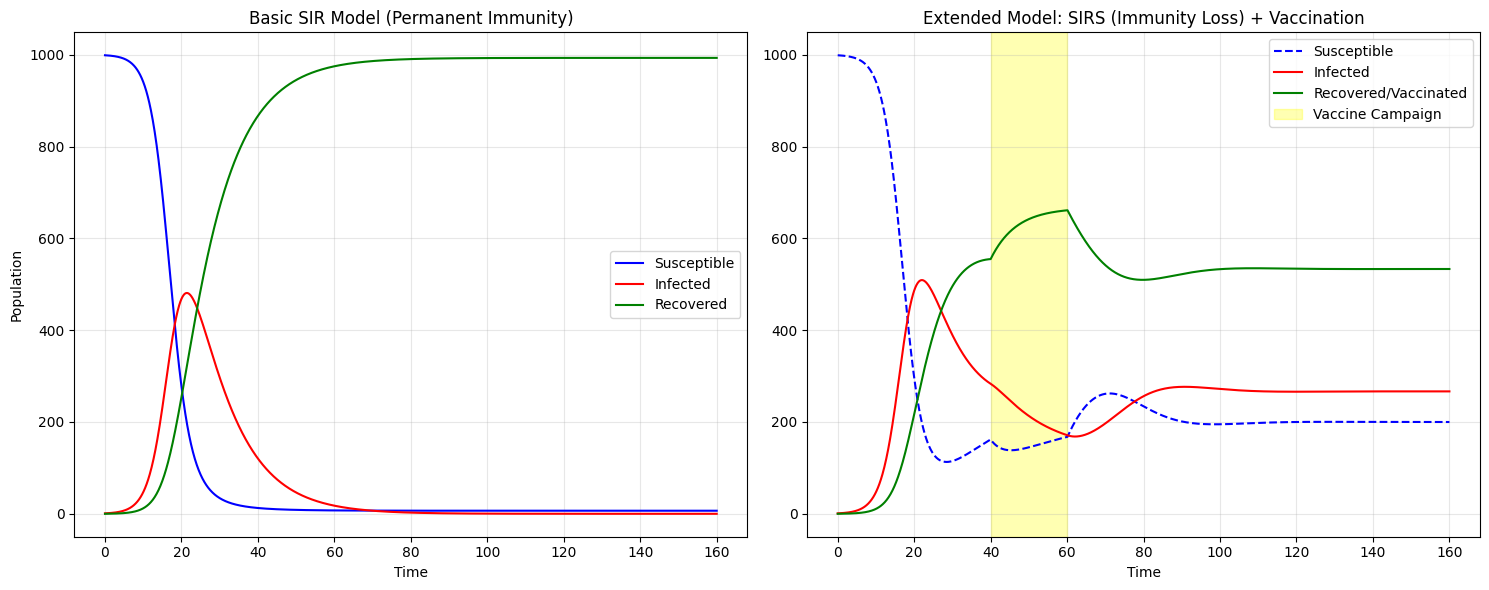

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 오일러 솔버 (시스템 ODE용 일반화 함수) ---
def solve_system_euler(f_func, u0, t, params):
    """
    시스템 ODE를 위한 순방향 오일러 솔버
    u: 벡터 [S, I, R]
    f_func: 도함수 계산 함수 (u' = f(u, t))
    """
    dt = t[1] - t[0]
    n_steps = len(t)

    # 상태 벡터 u를 저장할 배열 초기화 (시간 단계 x 변수 개수)
    # 예: u_hist[i] = [S_i, I_i, R_i]
    num_vars = len(u0)
    u_hist = np.zeros((n_steps, num_vars))

    # 초기값 설정
    u_hist[0] = u0

    # 오일러 루프 (Vectorized Operation)
    for i in range(n_steps - 1):
        # 현재 상태
        u_current = u_hist[i]

        # 변화율 계산 (f 함수 호출)
        dudt = f_func(u_current, t[i], params)

        # 다음 상태 업데이트: u(n+1) = u(n) + dt * f(u, t)
        # numpy 덕분에 배열끼리의 덧셈/곱셈이 한 번에 처리됨
        u_hist[i+1] = u_current + dt * np.array(dudt)

    return u_hist

# --- 2. 모델 정의 ---

# (A) 기본 SIR 모델
def sir_model(u, t, params):
    S, I, R = u
    beta, gamma, N, _, _ = params # 사용 안 하는 파라미터는 무시

    dS = -beta * S * I / N
    dI = (beta * S * I / N) - (gamma * I)
    dR = gamma * I

    return [dS, dI, dR]

# (B) 확장 모델: SIRS + 백신 캠페인 (불연속 계수)
def extended_sirs_vaccine_model(u, t, params):
    S, I, R = u
    beta, gamma, N, xi, vac_schedule = params

    # 1. 백신 접종률 v(t) 결정 (불연속적 상황 모델링)
    # vac_schedule = (start_time, end_time, rate)
    v_rate = 0.0
    if vac_schedule['start'] <= t <= vac_schedule['end']:
        v_rate = vac_schedule['rate'] # 캠페인 기간 동안 접종

    # 2. 미분 방정식 (면역 상실 및 백신 포함)
    # S -> I (감염)
    infection = beta * S * I / N
    # I -> R (회복)
    recovery = gamma * I
    # R -> S (면역 상실): 회복자의 일부가 다시 S로 돌아옴
    immunity_loss = xi * R
    # S -> R (백신 접종): 감염 경로를 거치지 않고 바로 면역 획득
    vaccination = v_rate * S

    dS = -infection + immunity_loss - vaccination
    dI = infection - recovery
    dR = recovery - immunity_loss + vaccination

    return [dS, dI, dR]

# --- 3. 시뮬레이션 설정 및 실행 ---
def run_simulation():
    # 파라미터
    N = 1000.0      # 총 인구
    I0 = 1.0        # 초기 감염자
    R0 = 0.0        # 초기 회복자
    S0 = N - I0 - R0 # 초기 감염 가능자
    u0 = [S0, I0, R0] # 초기 상태 벡터

    beta = 0.5      # 감염률
    gamma = 0.1     # 회복률 (평균 10일 앓음)
    xi = 0.05       # 면역 상실률 (회복 후 다시 감염 가능해짐)

    # 시간 설정
    dt = 0.1
    t_max = 160
    t = np.arange(0, t_max + dt, dt)

    # 백신 스케줄 (t=40 ~ t=60 동안 강력한 접종 캠페인)
    vaccine_params = {'start': 40, 'end': 60, 'rate': 0.1}

    # 파라미터 튜플로 포장
    params_basic = (beta, gamma, N, 0, {})
    params_ext = (beta, gamma, N, xi, vaccine_params)

    # 솔버 실행
    results_basic = solve_system_euler(sir_model, u0, t, params_basic)
    results_ext = solve_system_euler(extended_sirs_vaccine_model, u0, t, params_ext)

    # --- 4. 시각화 ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 그래프 1: 기본 SIR
    axes[0].plot(t, results_basic[:, 0], label='Susceptible', color='blue')
    axes[0].plot(t, results_basic[:, 1], label='Infected', color='red')
    axes[0].plot(t, results_basic[:, 2], label='Recovered', color='green')
    axes[0].set_title("Basic SIR Model (Permanent Immunity)")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Population")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 그래프 2: 확장 SIRS + 백신
    axes[1].plot(t, results_ext[:, 0], label='Susceptible', color='blue', linestyle='--') # 숙주
    axes[1].plot(t, results_ext[:, 1], label='Infected', color='red')
    axes[1].plot(t, results_ext[:, 2], label='Recovered/Vaccinated', color='green')

    # 백신 캠페인 기간 표시
    axes[1].axvspan(vaccine_params['start'], vaccine_params['end'], color='yellow', alpha=0.3, label='Vaccine Campaign')

    axes[1].set_title("Extended Model: SIRS (Immunity Loss) + Vaccination")
    axes[1].set_xlabel("Time")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_simulation()

### (1) 기본 SIR 모델
- 가정: 감염 후 회복하면 **영구 면역** 유지  
- 시뮬레이션 결과  
  - \(S\) (감염 가능자): 시간이 지나며 0에 수렴  
  - \(R\) (회복자): 전체 인구 수준까지 증가  
  - \(I\) (감염자): 감염 가능한 숙주가 사라지면서 자연 소멸  
- 결론: **질병 종식**

---

### (2) 확장 SIRS + 백신 모델
- 사용자 질문: “백신을 맞았는데 왜 질병이 사라지지 않는가?”
- 핵심 구조:  
  - 회복자 또는 백신 접종자는 시간이 지나면 **면역을 상실(\(R \to S\))**  
  - 단발성(일시적) 백신 캠페인은 장기적으로 지속 효과가 없음

#### 백신 캠페인(t = 40~60) 구간에서 나타난 효과
- \(S\) 급감 → 감염 가능 인구 감소  
- \(R\) 급증 → 백신 효과로 면역 보유자 증가  
- \(I\) 감소 → 전파 속도 둔화  
→ **백신은 분명히 효과가 있었음**

#### 그럼에도 질병이 사라지지 않는 이유
- 캠페인 종료 후  
  - 면역 상실(\(R \to S\))로 인해 **감염 가능자(S)가 다시 증가**  
  - 감염자(I)도 다시 늘어 **일정한 수준에서 유지되는 ‘엔데믹’ 상태**로 수렴  
- 결국  
  \[
  \text{면역을 잃는 속도} = \text{새로 감염 또는 백신으로 면역을 얻는 속도}
  \]
  이 되는 지점에서 균형 발생

---

## 3. 요약
- 백신 캠페인 실패가 아니라, **면역 지속 기간이 짧은 질병의 특징** 때문에  
  단발성 캠페인만으로는 박멸이 어려움  
- 독감·코로나19처럼 **면역 이탈(Immunity Loss)**이 있는 질병은  
  - **정기적 백신 접종(부스터)**  
  - 또는 **매우 긴 면역 유지 기간**  
  없이는 완전 퇴치가 어려움  
- 시뮬레이션이 보여주는 핵심 메시지  
  → **면역 상실이 존재하는 감염병은 장기적으로 ‘토착화(Endemic)’ 상태에 머묾**


Next Step for You: 이 모델을 더 발전시켜 **"사회적 거리두기"**의 효과를 시뮬레이션
- 감염 전파율 β를 시간 t에 따라 변하는 함수 β(t)(예: 거리두기 기간에는 0.2, 해제하면 0.5)로 설정하여 2차 유행(Second Wave)이 오는 상황을 코드로 구현

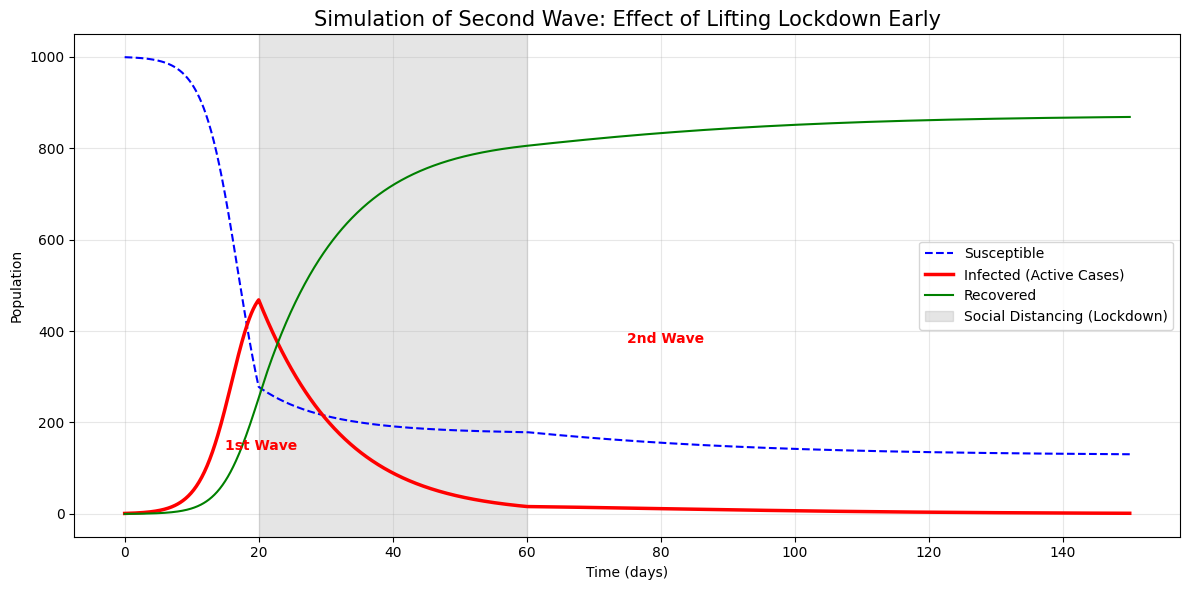

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 시간에 따라 변하는 베타 함수 정의 ---
def get_beta(t, beta_high, beta_low, start_day, end_day):
    """
    t 시점의 전파율 beta를 반환하는 함수
    - 거리두기 기간 (start_day <= t <= end_day)에는 낮은 beta 적용
    - 그 외 기간에는 높은 beta 적용
    """
    if start_day <= t <= end_day:
        return beta_low  # 사회적 거리두기 (Lockdown)
    return beta_high     # 일상 생활 (Normal)

# --- 2. SIR 모델 (Dynamic Beta 적용) ---
def sir_dynamic_model(u, t, params):
    S, I, R = u
    gamma, N, dist_params = params

    # 현재 시간 t에 맞는 beta 값을 가져옴
    beta = get_beta(t,
                    dist_params['high'],
                    dist_params['low'],
                    dist_params['start'],
                    dist_params['end'])

    # 미분 방정식
    dS = -beta * S * I / N
    dI = (beta * S * I / N) - (gamma * I)
    dR = gamma * I

    return np.array([dS, dI, dR]) # Numpy 배열로 반환

# --- 3. 오일러 솔버 ---
def solve_euler_dynamic(f_func, u0, t_array, params):
    dt = t_array[1] - t_array[0]
    n_steps = len(t_array)
    u_hist = np.zeros((n_steps, 3))
    u_hist[0] = u0

    for i in range(n_steps - 1):
        # 현재 상태에서 기울기 계산
        dudt = f_func(u_hist[i], t_array[i], params)
        # 업데이트
        u_hist[i+1] = u_hist[i] + dt * dudt

    return u_hist

# --- 4. 시뮬레이션 실행 ---
def run_second_wave_simulation():
    # 파라미터 설정
    N = 1000.0
    u0 = [999.0, 1.0, 0.0]  # S, I, R 초기값

    gamma = 0.1  # 회복률 (평균 감염 기간 10일)

    # 거리두기 시나리오 설정
    distancing_params = {
        'high': 0.5,   # 거리두기 없을 때 (R0 = 5)
        'low': 0.08,   # 강력한 거리두기 시행 (R0 = 0.8 < 1, 감염 감소)
        'start': 20,   # 20일부터 시작
        'end': 60      # 60일에 해제 (40일간 지속)
    }

    # 시간 설정
    dt = 0.1
    t_max = 150
    t = np.arange(0, t_max + dt, dt)

    # 파라미터 패키징
    params = (gamma, N, distancing_params)

    # 솔버 실행
    results = solve_euler_dynamic(sir_dynamic_model, u0, t, params)

    S, I, R = results[:, 0], results[:, 1], results[:, 2]

    # --- 5. 시각화 ---
    fig, ax = plt.subplots(figsize=(12, 6))

    # SIR 곡선 그리기
    ax.plot(t, S, label='Susceptible', color='blue', linestyle='--')
    ax.plot(t, I, label='Infected (Active Cases)', color='red', linewidth=2.5)
    ax.plot(t, R, label='Recovered', color='green')

    # 거리두기 기간 배경색 표시
    ax.axvspan(distancing_params['start'], distancing_params['end'],
               color='gray', alpha=0.2, label='Social Distancing (Lockdown)')

    # 텍스트 주석 추가 (1차, 2차 유행)
    ax.text(15, max(I)*0.3, "1st Wave", color='red', fontweight='bold')
    ax.text(75, max(I)*0.8, "2nd Wave", color='red', fontweight='bold')

    # 그래프 꾸미기
    ax.set_title("Simulation of Second Wave: Effect of Lifting Lockdown Early", fontsize=15)
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Population")
    ax.legend(loc='center right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_second_wave_simulation()

# 2차 유행이 더 크게 나타나는 이유 정리 (Twin Peaks 현상)

## 1. 1차 유행 (t = 0 ~ 20)
- 감염자 수가 빠르게 증가하며 첫 번째 정점을 형성  
- 감염재생산지수 \(R_t > 1\) 상태  
- 자연 감염으로 생성된 면역자(Recovered)는 아직 충분하지 않음

---

## 2. 거리두기 구간 (t = 20 ~ 60)
- 정책: 전파율 \(\beta\)를 **0.08**로 낮춤  
- 효과  
  - \(R_t < 1\)이 되어 감염자 수가 급감  
  - 그래프 상에서 **회색 영역**은 성공적으로 보이는 방역의 시기  
- 그러나 중요한 구조적 한계  
  - 전파를 억제하는 동안 감염 자체가 줄어들기 때문에  
    → **면역자(Recovered)가 충분히 쌓이지 않음**  
  - 즉, 집단 면역 수준에 도달하지 못함

---

## 3. 2차 유행 (t = 60 이후)
- 거리두기 해제와 함께 \(\beta\)가 원래 값으로 회복  
- 억눌려 있던 감염이 폭발적으로 재확산  
- 핵심 원인  
  - 여전히 감염 가능한 인구 \(S\)가 **높은 상태**  
  - 1차 유행에서 만들어진 면역자 수가 부족  
  - 덕분에 감염 재생산지수 \(R_t\)가 크게 상승  
- 결과:  
  - **2차 유행의 규모가 1차 유행보다 더 크고 더 높게 발생**  
  - 그래프 형태가 “낙타 등(Twin Peaks)” 구조로 나타남

---

## 4. 모델이 보여주는 역학적 교훈
- 거리두기는 **전파를 늦추는 도구**일 뿐  
- 유행 자체를 끝내지는 못함  
- 백신, 항체 치료제, 지속적 면역 확보 없이  
  거리두기만 반복하는 것은 **재확산을 지연할 뿐**  
- 방역을 풀면 다시 큰 유행이 발생할 수 있음을 시각적으로 확인할 수 있음



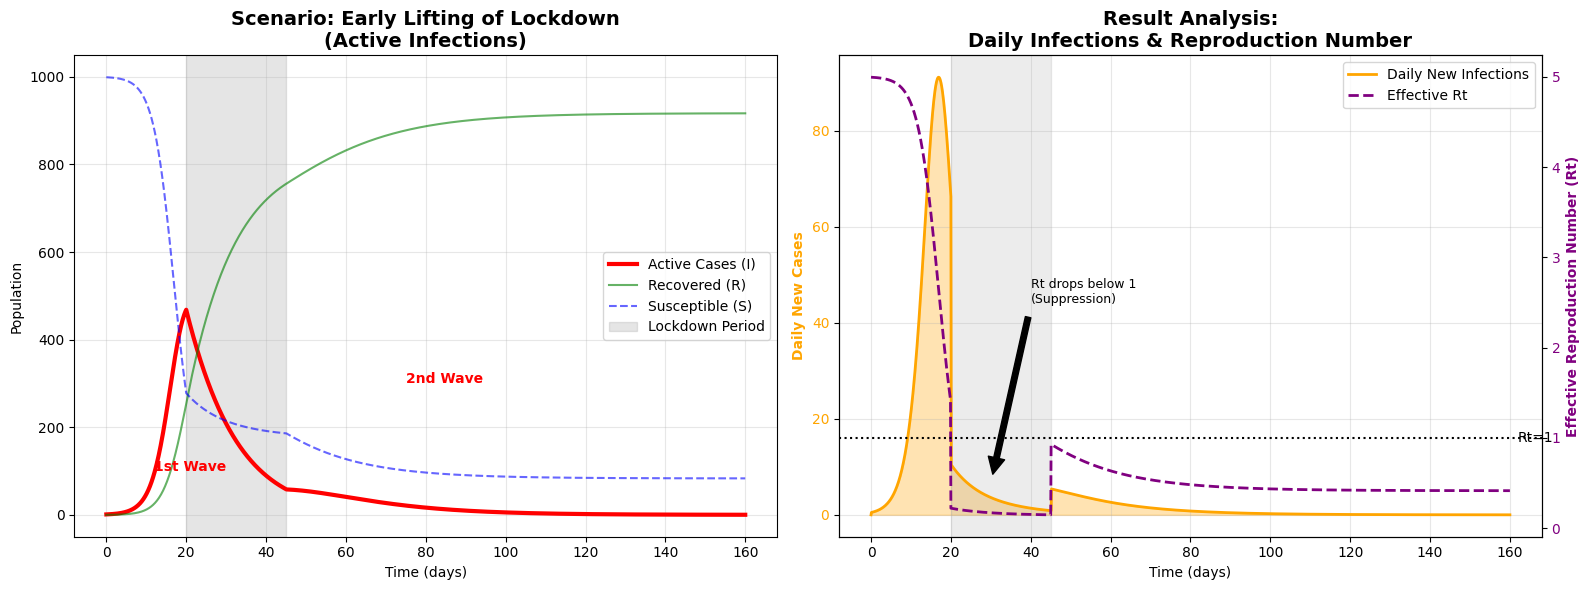

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 시뮬레이션 엔진 (SIR 모델 + 일일 확진자 계산)
# ==========================================
def run_simulation_with_daily_stats():
    # 파라미터 설정
    N = 1000.0             # 전체 인구
    I0, R0 = 1.0, 0.0      # 초기 감염자, 회복자
    S0 = N - I0 - R0       # 초기 감염 가능자

    gamma = 0.1            # 회복률 (감염 기간 10일)

    # 사회적 거리두기 시나리오
    # beta_high: 일상 (R0 = 5.0) / beta_low: 거리두기 (R0 = 0.8)
    # dist_params = {'beta_high': 0.5, 'beta_low': 0.08, 'start': 20, 'end': 60}
    dist_params = {'beta_high': 0.5, 'beta_low': 0.08, 'start': 20, 'end': 45}

    # 시간 설정
    dt = 0.1
    t_max = 160
    t_array = np.arange(0, t_max + dt, dt)
    n_steps = len(t_array)

    # 결과 저장용 배열
    S = np.zeros(n_steps)
    I = np.zeros(n_steps)
    R = np.zeros(n_steps)
    daily_new_cases = np.zeros(n_steps) # 일일 신규 확진자 (순간 변화율)
    Rt_history = np.zeros(n_steps)      # 실시간 감염 재생산지수 (Rt)

    # 초기값
    S[0], I[0], R[0] = S0, I0, R0

    # 오일러 방법 루프
    for i in range(n_steps - 1):
        # 현재 시점의 Beta 결정
        if dist_params['start'] <= t_array[i] <= dist_params['end']:
            current_beta = dist_params['beta_low']
        else:
            current_beta = dist_params['beta_high']

        # 미분 방정식 계산
        new_infections = current_beta * S[i] * I[i] / N  # 신규 감염 발생
        recoveries = gamma * I[i]                        # 회복 발생

        dS = -new_infections
        dI = new_infections - recoveries
        dR = recoveries

        # 상태 업데이트
        S[i+1] = S[i] + dt * dS
        I[i+1] = I[i] + dt * dI
        R[i+1] = R[i] + dt * dR

        # 분석용 데이터 저장
        daily_new_cases[i+1] = new_infections # 단위 시간당 신규 감염자
        Rt_history[i] = (current_beta / gamma) * (S[i] / N) # 유효 감염 재생산지수

    Rt_history[-1] = Rt_history[-2] # 마지막 값 보정

    return t_array, S, I, R, daily_new_cases, Rt_history, dist_params

# ==========================================
# 2. 시각화 (좌: 전체 유행 곡선 / 우: 정책 결과 분석)
# ==========================================
def visualize_results():
    t, S, I, R, daily_cases, Rt, dist_params = run_simulation_with_daily_stats()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- [왼쪽 그림] 사회적 거리두기와 2차 유행 (전체 인구 변화) ---
    ax1 = axes[0]
    ax1.plot(t, I, 'r-', linewidth=3, label='Active Cases (I)')
    ax1.plot(t, R, 'g-', alpha=0.6, label='Recovered (R)')
    ax1.plot(t, S, 'b--', alpha=0.6, label='Susceptible (S)')

    # 거리두기 기간 표시 (회색 영역)
    ax1.axvspan(dist_params['start'], dist_params['end'], color='gray', alpha=0.2, label='Lockdown Period')

    # 텍스트 주석
    ax1.text(12, 100, "1st Wave", color='red', fontweight='bold')
    ax1.text(75, 300, "2nd Wave", color='red', fontweight='bold')

    ax1.set_title("Scenario: Early Lifting of Lockdown\n(Active Infections)", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel("Population")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- [오른쪽 그림] 정책의 결과 (일일 신규 확진자 & Rt) ---
    ax2 = axes[1]

    # (1) 일일 신규 확진자 (막대 그래프 느낌으로 표현)
    # 오일러 dt가 0.1이므로 '하루' 단위로 보여주기 위해 스케일링이 필요할 수 있으나, 여기선 추세 확인용으로 플롯
    ax2.plot(t, daily_cases, color='orange', linewidth=2, label='Daily New Infections')
    ax2.fill_between(t, daily_cases, color='orange', alpha=0.3)

    ax2.set_ylabel("Daily New Cases", color='orange', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='orange')

    # (2) 감염 재생산지수 (Rt) - 이중 Y축 사용
    ax3 = ax2.twinx()
    ax3.plot(t, Rt, color='purple', linestyle='--', linewidth=2, label='Effective Rt')
    ax3.set_ylabel("Effective Reproduction Number (Rt)", color='purple', fontweight='bold')
    ax3.tick_params(axis='y', labelcolor='purple')

    # Rt = 1 기준선 (이보다 높으면 유행 확산)
    ax3.axhline(1.0, color='black', linestyle=':', linewidth=1.5)
    ax3.text(t[-1]+2, 1.0, "Rt=1", va='center')

    # 거리두기 기간 표시
    ax2.axvspan(dist_params['start'], dist_params['end'], color='gray', alpha=0.15)

    # 화살표 주석: 거리두기 효과
    ax3.annotate('Rt drops below 1\n(Suppression)', xy=(30, 0.5), xytext=(40, 2.5),
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9)

    ax2.set_title("Result Analysis:\nDaily Infections & Reproduction Number", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Time (days)")

    # 범례 합치기 (꼼수)
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_results()